## Applying Neural Networks to Business Problems

Now that you've seen how to train simple neural networks and avoid the problem of overfitting, let's try training a more complex neural network to predict business-relevant events. 

First, let's set up some imports that we'll need later:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Preparing our Input Data

Let's import our training and test data:

In [2]:
train_df = pd.read_csv("data/sales-train.csv")
test_df = pd.read_csv("data/sales-test.csv")

We can examine each of these dataframes in turn:

In [3]:
train_df.head()

,Age,Income,Female,Purchased
0,43,50,0,0
1,24,59,1,1
2,41,55,1,0
3,32,302,1,1
4,39,66,0,1


In [4]:
test_df.tail()

,Age,Income,Female,Purchased
174,24,121,0,1
175,35,69,1,1
176,54,53,0,0
177,34,49,0,0
178,44,50,0,0


As you can see, these datasets concern whether a given consumer has purchased from our business in the past. Each row represents a different consumer. We seek to predict values of the `Purchased` column (`1` for a consumer that did purchase and `0` for a consumer that declined) using the profile data in the other columns. 

Let's pull out the `X` and `y` variables in our data:

In [5]:
X_train, y_train = (
    train_df.drop('Purchased', axis=1).to_numpy(),
    train_df.Purchased.to_numpy()
)
X_test, y_test = (
    test_df.drop('Purchased', axis=1).to_numpy(),
    test_df.Purchased.to_numpy()
)

In order to train our network effectively, we'll need to *scale* our input data to be within an appropriate well-defined range. Let's choose the range `(0,1)`:

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1), copy=True)
X_train_scaled = scaler.fit_transform(X_train)

Note that we have only used the training dataset to construct our `scaler` object - do not use the test dataset for this part, that would be cheating! No aspect of constructing our model is allowed to rely on our test dataset - if we break this rule, we will not be able to accurately estimate how well our model can generalize to unseen data.

## Building a Neural Network to Predict Purchases

The network we will use will consist of one hidden layer compused of ReLU neurons, followed by an output layer that uses the softmax activation function to produce probability estimates for whether or not the consumer made a purchase. 

Before we do anything, we'll need to run the following code to ensure that the randomness used in tensorflow is appropriately controlled so that your result can match ours:

In [7]:
from consistency import remove_randomness
remove_randomness()

Let's initialize this network:

In [8]:
import tensorflow as tf
from tensorflow import keras

model_nn = keras.Sequential([
    keras.layers.Dense(
        units=50,
        input_shape=(X_train.shape[1],),
        activation="relu",
        name="hidden"
    ),
    keras.layers.Dense(
        units=2,
        activation="softmax",
        name="output"
    )
])

We will now configure the model for training - since we're performing *classification* (labeling a customer as either a `1` or a `0`) rather than *regression* (predicting a number like "revenue" that can take on a wide range of values), we need to use a different loss function to guide our training process, `categorical_crossentropy`:

In [9]:
model_nn.compile(
    loss="categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"]
)

Finally, we train the model - note that we need to call `to_categorical` to convert our `y_train` data into the appropriate format expected by TensorFlow for classification problems:

In [10]:
model_nn.fit(
    X_train_scaled,
    keras.utils.to_categorical(y_train),
    epochs=5
)

Train on 535 samples
Epoch 1/5
535/535 [==============================] - 1s 948us/sample - loss: 0.6579 - accuracy: 0.7682
Epoch 2/5
535/535 [==============================] - 0s 42us/sample - loss: 0.6434 - accuracy: 0.7832
Epoch 3/5
535/535 [==============================] - 0s 147us/sample - loss: 0.6308 - accuracy: 0.7869
Epoch 4/5
535/535 [==============================] - 0s 155us/sample - loss: 0.6201 - accuracy: 0.7869
Epoch 5/5
535/535 [==============================] - 0s 38us/sample - loss: 0.6107 - accuracy: 0.7869


Let's see how it performs on the test dataset:

In [11]:
X_test_scaled = scaler.transform(X_test)
model_nn.evaluate(
    X_test_scaled, 
    keras.utils.to_categorical(y_test)
)

179/179 [==============================] - 0s 964us/sample - loss: 0.6211 - accuracy: 0.7542


[0.6211078403382327, 0.75418997]

The first number above is the loss function value, which we can ignore for now. The accuracy on the test set is the second number in the list above. We can see that the accuracy is slightly lower on the test set, but not by much.

## Assessing the Precision of Our Neural Network

Suppose that you are asked to justify the time spent developing this model. How much will it increase the efficiency of your sales team to have leads pre-vetted using the model's predicitons? To answer this question, we need to consider the current state of our business - how many leads currently convert? We can see that our training set contains `218` purchasers and `317` who declined to purchase:

In [12]:
train_df['Purchased'].value_counts()

0    317
1    218
Name: Purchased, dtype: int64

So with the current "call everyone on the list" approach, our sales team will have a hit rate of `218/(218 + 317) ~= 40%`. What if they use our model instead and only call the people who are predicted to be buyers? 

The number that we want to know is called the *precision* of our model: what fraction of its "positive" predictions will actually turn out to be positive? This will be the hit rate observed by our sales team. Let's take a look at the output of our model in order to understand how to calculate the precision:

In [13]:
y_probs_test = model_nn.predict(X_test_scaled)

Notice that the model has output *pairs of probabilities* - the probability (estimated by the model) that the customer under examination is a `1` or a `0`:

In [14]:
y_probs_test

array([[0.6112734 , 0.38872662],
       [0.5469387 , 0.4530613 ],
       [0.4272427 , 0.5727573 ],
       [0.4272792 , 0.5727208 ],
       [0.6133764 , 0.38662362],
       [0.5595109 , 0.44048908],
       [0.43077347, 0.5692265 ],
       [0.45188707, 0.54811287],
       [0.42572072, 0.57427925],
       [0.42131472, 0.5786853 ],
       [0.42155805, 0.578442  ],
       [0.43061522, 0.56938475],
       [0.5971134 , 0.40288663],
       [0.60667175, 0.39332825],
       [0.5113386 , 0.4886614 ],
       [0.5856206 , 0.41437948],
       [0.58538824, 0.41461176],
       [0.42045087, 0.5795492 ],
       [0.5906378 , 0.40936226],
       [0.45298192, 0.5470181 ],
       [0.41914898, 0.580851  ],
       [0.4473601 , 0.5526399 ],
       [0.4122974 , 0.5877026 ],
       [0.6129073 , 0.38709274],
       [0.5830572 , 0.4169428 ],
       [0.5755006 , 0.4244994 ],
       [0.5730792 , 0.42692074],
       [0.588386  , 0.411614  ],
       [0.4142656 , 0.58573437],
       [0.6067475 , 0.39325252],
       [0.

The *precision* of our model will depend on the cutoff value we choose for these probabilities. If we choose a very high cutoff value (say, `0.9`) and label all leads below the cutoff as "not-likely buyers" and all customers above the cutoff as "likely buyers," the precision of our model will be very high - almost everyone who it labels a "likely buyer" will actually buy. However, the *recall* of the model will be low - it will only identify a small number of the customers who actually would have made a purchase. Our sales team will be efficient, but their overall productivity will be low because they will only have a few leads to call. 

This problem, then, is similar to the tradeoffs we discussed in our earlier section on the merits of ROC curves. We need to analyze a range of cutoff (threshold) values and assess the tradeoffs in terms of precision and recall that each one entails. We will therefore construct a 'precision-recall curve' using the code below:

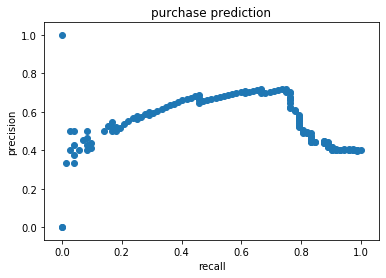

In [15]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresh = precision_recall_curve(y_test, y_probs_test[:,1])
plt.scatter(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('purchase prediction')
plt.show()

Notice the following about this graph:

* The `precision` value eventually converges to the fraction of `1` values in our dataset - if we classify everyone as a `1` and call every customer, this is the fraction that will end up buying. 
* The `recall` value converges to `1.0` - if we call everyone, we'll get all the potential buyers, but we'll spend more time on the phone. 
* There are a few scattered points with very high precision and very low recall. These correspond to high cutoff values, so only a few buyers are identified but our confidence in these buyers is very high. 

Suppose we choose the following point:

In [16]:
point_idx = 80 
print("thresh:", thresh[point_idx])
print("precision:", precision[point_idx])
print("recall:", recall[point_idx])

thresh: 0.4382023
precision: 0.72
recall: 0.75


If we apply this thresh cutoff value to our model's predictions, we can expect roughly three-quarters of our model's predicted purchasers to actually convert. This will be a much higher hit rate than simply calling everyone on this list - while calling everyone on the list is a better approach if our sales personnel costs are low, prioritizing effectively will increase our returns in many cases. 

<span style="color:blue;font-weight:bold">Exercise</span>: Let's see if there's any more accuracy we can squeeze out of our model. Perform the following tasks:

* Construct a model `model_larger` that is identical to the `model_nn` we created above, with the exception of the number of units in the hidden layer, which should be set to `100` rather than `50`. 
* Your call to `model_larger.compile` to configure your model for training should use the same parameters as we used previously
* Train this model on `(X_train_scaled, y_train)`, but run your training for `7` epochs this time 
* Evaluate your model on `(X_test_scaled, y_test)` - store your result in the variable `evaluation_result` 

Be careful not to delete the call to `remove_randomness()` that we have included below.

In [23]:
remove_randomness()

model_larger = tf.keras.Sequential([
    keras.layers.Dense(
        units=100,
        input_shape=(X_train.shape[1],),
        activation="relu",
        name="hidden"
    ),
    keras.layers.Dense(
        units=2,
        activation="softmax",
        name="output"
    )
])

model_larger.compile(
    loss="categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"]
)

history = model_larger.fit(X_train_scaled, keras.utils.to_categorical(y_train), epochs=7)

evaluation_result = model_larger.evaluate(X_test_scaled, keras.utils.to_categorical(y_test))

Train on 535 samples
Epoch 1/7
535/535 [==============================] - 0s 776us/sample - loss: 0.7044 - accuracy: 0.5701
Epoch 2/7
535/535 [==============================] - 0s 156us/sample - loss: 0.6868 - accuracy: 0.5944
Epoch 3/7
535/535 [==============================] - 0s 42us/sample - loss: 0.6715 - accuracy: 0.6075
Epoch 4/7
535/535 [==============================] - 0s 149us/sample - loss: 0.6581 - accuracy: 0.6187
Epoch 5/7
535/535 [==============================] - 0s 151us/sample - loss: 0.6459 - accuracy: 0.6879
Epoch 6/7
535/535 [==============================] - 0s 42us/sample - loss: 0.6347 - accuracy: 0.7626
Epoch 7/7
179/179 [==============================] - 0s 2ms/sample - loss: 0.6278 - accuracy: 0.7654


In [23]:
check_variable_definition("model_larger")
assert str(type(model_larger)) ==  "<class 'tensorflow.python.keras.engine.sequential.Sequential'>", "Your variable <code>my_model</code> does not contain an object of the right type - did you create it using <code>keras.Seqential()</code>?"
assert len(model_larger.layers) == 2, "Your model does not contain the correct number of layers."
assert model_larger.layers[0].name == 'hidden', "Your hidden layer does not have the correct name value."
assert model_larger.layers[1].name == 'output', "Your output layer does not have the correct name value."
assert model_larger.layers[0].units == 100, "Your hidden layer does not contain the correct number of neurons."
assert model_larger.layers[1].units == 2, "Your output layer does not contain the correct number of neurons."
assert abs(evaluation_result[1]  - 0.76) < 0.01, "Your accuracy does not match the expected value - check your training process and your call to <code>evaluate</code>"
success()

Note that the larger model eventually gives a similar accuracy score to the smaller one, but takes slightly longer to train to a similar level of accuracy. More is not always better. 

In [24]:
evaluation_result

[0.6277970065617694, 0.76536316]

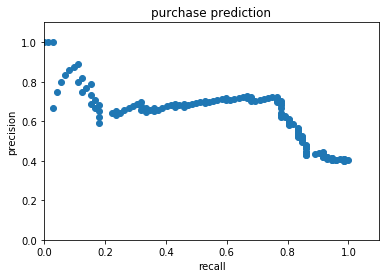

In [28]:
y_probs_test = model_larger.predict(X_test_scaled)

precision, recall, thresh = precision_recall_curve(y_test, y_probs_test[:,1])
plt.scatter(recall, precision)
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('purchase prediction')
plt.show()